# Unit 5 - Financial Planning

In [13]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

%matplotlib inline

In [14]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [15]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [16]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [17]:
# Fetch current BTC price
from pprint import pprint
response_btc=requests.get(btc_url).json()
pprint(response_btc['data']['1']['quotes']['CAD']['price'])
btc_price=(response_btc['data']['1']['quotes']['CAD']['price'])

58968.75


In [18]:
# Fetch current ETH price
from pprint import pprint
response_eth=requests.get(eth_url).json()
response_eth
pprint(response_eth['data']['1027']['quotes']['CAD']['price'])
eth_price=(response_eth['data']['1027']['quotes']['CAD']['price'])

4206.325


In [19]:
# Compute current value of my crpto
my_btc_value=my_btc*btc_price
my_eth_value=my_eth*eth_price
# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $70762.50
The current value of your 5.3 ETH is $22293.52


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [20]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [21]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

In [22]:
# Verify that Alpaca key and secret were correctly loaded
print(f"Alpaca Key type: {type(alpaca_api_key)}")
print(f"Alpaca Secret Key type: {type(alpaca_secret_key)}")

Alpaca Key type: <class 'str'>
Alpaca Secret Key type: <class 'str'>


In [23]:
# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [24]:
# Format current date as ISO format
today = pd.Timestamp("2020-05-01", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
df_portfolio = alpaca.get_bars(
    tickers,
    timeframe,
    start = today,
    end = today,
).df

# Reorganize the DataFrame
# Separate ticker data
AGG = df_portfolio[df_portfolio['symbol']=='AGG'].drop('symbol', axis=1)
SPY = df_portfolio[df_portfolio['symbol']=='SPY'].drop('symbol', axis=1)
# Concatenate the ticker DataFrames
df_portfolio = pd.concat([AGG, SPY],axis=1, keys=['AGG','SPY'])

# Display sample data
df_portfolio

AGG                                       \
                             open      high       low   close   volume   
timestamp                                                                
2020-05-01 04:00:00+00:00  116.97  117.0998  116.6775  116.87  6099893   

                                                      SPY                    \
                          trade_count        vwap    open      high     low   
timestamp                                                                     
2020-05-01 04:00:00+00:00       24395  116.846123  285.16  290.6572  281.52   

                                                                      
                            close     volume trade_count        vwap  
timestamp                                                             
2020-05-01 04:00:00+00:00  282.79  125180028      639987  284.092832

In [25]:
# Pick AGG and SPY close prices
agg_close_price = float(df_portfolio["AGG"]["close"])
spy_close_price = float(df_portfolio["SPY"]["close"])
# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $116.87
Current SPY closing price: $282.79


In [26]:
# Compute the current value of shares
agg_value = agg_close_price * my_agg
spy_value = spy_close_price * my_spy
# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${agg_value:0.2f}")

The current value of your 50 SPY shares is $14139.50
The current value of your 200 AGG shares is $23374.00


### Savings Health Analysis

In [27]:
# Set monthly household income
monthly_income=12000

# Consolidate financial assets data
shares = agg_value+spy_value
crypto = my_btc_value+my_eth_value

# Create savings DataFrame
df_savings = {
    "amount": [shares, crypto]
}

# Set the tickers
tickers = ["shares", "crypto"]

# Create the shares DataFrame
df_savings = pd.DataFrame(df_savings, index=tickers)

# Display shares data
df_savings

,amount
shares,37513.5000
crypto,93056.0225


<AxesSubplot:title={'center':'Composition of Personal Savings'}, ylabel='amount'>

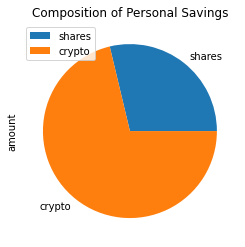

In [28]:
# Plot savings pie chart
df_savings.plot.pie(y="amount", title="Composition of Personal Savings")

In [29]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
savings = shares + crypto

balance = emergency_fund - savings

# Validate saving health
if savings > emergency_fund:
    print('Congratulations! You have enough money in your emergency fund')
elif savings == emergency_fund:
    print ('Congratulations! You have reached your finacial goal')
elif savings < emergency_fund:
     print (f"Almost there! You need ${balance:0.2f}")

Congratulations! You have enough money in your emergency fund


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [30]:
# Set start and end dates of five years back from today.
start_date = pd.Timestamp('2017-03-23', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2022-03-23', tz='America/New_York').isoformat()

In [31]:
# Get 5 years' worth of historical data for SPY and AGG
# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)
df_portfolio2 = alpaca.get_bars(
    tickers,
    timeframe,
    start = start_date,
    end = end_date,
).df

# Reorganize the DataFrame
# Separate ticker data
AGG = df_portfolio2[df_portfolio2["symbol"]=="AGG"].drop("symbol", axis=1)
SPY = df_portfolio2[df_portfolio2["symbol"]=="SPY"].drop("symbol", axis=1)

# Concatenate the ticker DataFrames
df_ticker = pd.concat([AGG, SPY], axis=1, keys=["AGG","SPY"])

# Display sample data
df_ticker

AGG                                       \
                             open     high       low   close    volume   
timestamp                                                                
2017-03-23 04:00:00+00:00  108.44  108.510  108.2635  108.45   2071485   
2017-03-24 04:00:00+00:00  108.35  108.510  108.3100  108.36   3374871   
2017-03-27 04:00:00+00:00  108.65  108.710  108.5345  108.62   1977292   
2017-03-28 04:00:00+00:00  108.63  108.680  108.3500  108.37   2016097   
2017-03-29 04:00:00+00:00  108.48  108.620  108.4600  108.61   1965626   
...                           ...      ...       ...     ...       ...   
2022-03-17 04:00:00+00:00  107.90  108.060  107.7300  107.86   8005258   
2022-03-18 04:00:00+00:00  107.93  108.140  107.9203  108.10   7800354   
2022-03-21 04:00:00+00:00  107.58  107.649  106.9841  107.04   7583668   
2022-03-22 04:00:00+00:00  106.74  106.880  106.6100  106.75  16048681   
2022-03-23 04:00:00+00:00  106.96  107.210  106.7105  107.19   8567200   

                                                      SPY                   \
                          trade_count        vwap    open    high      low   
timestamp                                                                    
2017-03-23 04:00:00+00:00       10901  108.417635  233.98  235.34  233.600   
2017-03-24 04:00:00+00:00       11229  108.398485  234.35  235.04  232.960   
2017-03-27 04:00:00+00:00       11112  108.600681  231.97  233.92  231.610   
2017-03-28 04:00:00+00:00        9144  108.514754  233.32  235.81  233.140   
2017-03-29 04:00:00+00:00       10135  108.539517  235.00  235.81  234.725   
...                               ...         ...     ...     ...      ...   
2022-03-17 04:00:00+00:00       24093  107.889900  433.70  441.07  433.190   
2022-03-18 04:00:00+00:00       23567  108.060585  437.81  444.86  437.220   
2022-03-21 04:00:00+00:00       27316  107.310151  444.45  446.46  440.680   
2022-03-22 04:00:00+00:00       51796  106.746967  445.99  450.58  445.860   
2022-03-23 04:00:00+00:00       27348  106.991875  446.90  448.49  443.710   

                                                                      
                            close     volume trade_count        vwap  
timestamp                                                             
2017-03-23 04:00:00+00:00  234.03  100410277      333903  234.388790  
2017-03-24 04:00:00+00:00  233.86  112504853      359600  234.080978  
2017-03-27 04:00:00+00:00  233.62   87454452      289784  233.041576  
2017-03-28 04:00:00+00:00  235.32   93483915      277352  234.596748  
2017-03-29 04:00:00+00:00  235.54   61950354      194177  235.429910  
...                           ...        ...         ...         ...  
2022-03-17 04:00:00+00:00  441.07  100157174      784018  437.706981  
2022-03-18 04:00:00+00:00  444.31  102327793      790235  441.458916  
2022-03-21 04:00:00+00:00  444.30   85377983      912432  443.796432  
2022-03-22 04:00:00+00:00  449.59   73674202      623610  448.558595  
2022-03-23 04:00:00+00:00  443.80   77982935      627281  446.058683  

[1260 rows x 14 columns]

In [32]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_even_dist = MCSimulation(
    portfolio_data = df_ticker,
    weights = [.4,.6],
    num_simulation = 500,
    num_trading_days = 252*30
)
# Print the simulation input data
MC_even_dist.portfolio_data.head()

AGG                                     \
                             open    high       low   close   volume   
timestamp                                                              
2017-03-23 04:00:00+00:00  108.44  108.51  108.2635  108.45  2071485   
2017-03-24 04:00:00+00:00  108.35  108.51  108.3100  108.36  3374871   
2017-03-27 04:00:00+00:00  108.65  108.71  108.5345  108.62  1977292   
2017-03-28 04:00:00+00:00  108.63  108.68  108.3500  108.37  2016097   
2017-03-29 04:00:00+00:00  108.48  108.62  108.4600  108.61  1965626   

                                                                   SPY  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2017-03-23 04:00:00+00:00       10901  108.417635          NaN  233.98   
2017-03-24 04:00:00+00:00       11229  108.398485    -0.000830  234.35   
2017-03-27 04:00:00+00:00       11112  108.600681     0.002399  231.97   
2017-03-28 04:00:00+00:00        9144  108.514754    -0.002302  233.32   
2017-03-29 04:00:00+00:00       10135  108.539517     0.002215  235.00   

                                                                           \
                             high      low   close     volume trade_count   
timestamp                                                                   
2017-03-23 04:00:00+00:00  235.34  233.600  234.03  100410277      333903   
2017-03-24 04:00:00+00:00  235.04  232.960  233.86  112504853      359600   
2017-03-27 04:00:00+00:00  233.92  231.610  233.62   87454452      289784   
2017-03-28 04:00:00+00:00  235.81  233.140  235.32   93483915      277352   
2017-03-29 04:00:00+00:00  235.81  234.725  235.54   61950354      194177   

                                                    
                                 vwap daily_return  
timestamp                                           
2017-03-23 04:00:00+00:00  234.388790          NaN  
2017-03-24 04:00:00+00:00  234.080978    -0.000726  
2017-03-27 04:00:00+00:00  233.041576    -0.001026  
2017-03-28 04:00:00+00:00  234.596748     0.007277  
2017-03-29 04:00:00+00:00  235.429910     0.000935

In [35]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_even_dist.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.004320,0.999020,1.004766,1.007562,0.991546,0.997570,1.015304,1.007526,1.006564,0.998383,...,0.996406,1.002755,1.001363,1.014777,1.005627,0.999979,1.020164,1.000947,1.007650,0.984662
2,1.003318,0.997426,0.996271,0.996812,0.997448,1.004705,1.015168,1.003086,1.004506,0.993848,...,0.996539,1.011144,0.994970,1.008523,1.011705,0.996131,1.016582,0.999335,1.013857,0.982185
3,1.007799,1.011349,1.002059,1.003941,1.005816,1.005383,1.016458,0.990502,1.005132,1.000078,...,0.990753,1.019157,0.987500,1.010770,1.008422,0.988925,1.022107,0.999931,1.011865,0.974741
4,1.000830,1.021867,1.014835,1.011377,0.996076,1.003252,1.018409,1.007466,1.005498,0.985903,...,0.978006,1.019872,0.989941,1.003479,1.008229,0.981556,1.028222,1.005380,1.011168,0.968569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,5.967190,27.825749,22.884486,17.501025,7.961645,15.303485,16.511323,6.307408,4.729150,30.909671,...,24.989851,12.295902,11.470636,34.978313,25.479556,3.352309,18.406885,17.972023,4.483085,12.163215
7557,5.946461,28.119629,22.930732,17.458821,8.040572,15.455099,16.623672,6.347397,4.782851,30.656933,...,24.675866,12.391962,11.587180,34.614039,25.473037,3.330900,18.369275,17.981734,4.427329,12.225437
7558,5.908525,28.068876,23.096088,17.640652,8.074469,15.318078,16.631786,6.340028,4.796027,30.516803,...,24.858893,12.370505,11.643646,34.693925,25.318162,3.325316,18.255470,18.147256,4.430213,12.141924
7559,5.854445,27.744410,23.133275,17.724505,8.101423,15.385544,16.674263,6.320647,4.759592,30.433708,...,24.915584,12.449354,11.625023,34.112810,25.528565,3.335032,18.490223,18.303307,4.401824,12.205075


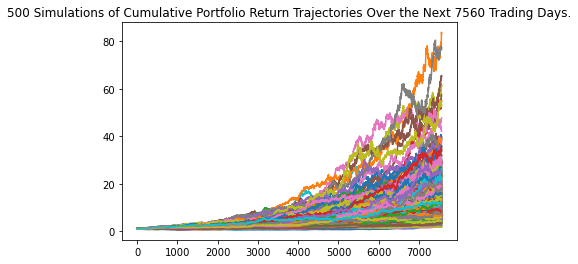

In [36]:
# Plot simulation outcomes
line_plot = MC_even_dist.plot_simulation()

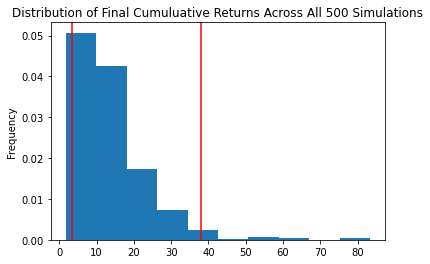

In [47]:
# Plot probability distribution and confidence intervals
dist_plot = MC_even_dist.plot_distribution()

### Retirement Analysis

In [48]:
# Fetch summary statistics from the Monte Carlo simulation results
even_tbl = MC_even_dist.summarize_cumulative_return()

# Print summary statistics
print(even_tbl)

count           500.000000
mean             13.827752
std              10.165194
min               1.719824
25%               7.235166
50%              11.393093
75%              17.721217
max              83.378433
95% CI Lower      3.375323
95% CI Upper     37.959516
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [49]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
even_ci_lower = round(even_tbl[8]*20000,2)
even_ci_upper = round(even_tbl[9]*20000,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${even_ci_lower} and ${even_ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $67506.47 and $759190.32


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [50]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
even_ci_lower = round(even_tbl[8]*30000,2)
even_ci_upper = round(even_tbl[9]*30000,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${even_ci_lower} and ${even_ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $101259.7 and $1138785.47


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [51]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_even_dist2 = MCSimulation(
    portfolio_data = df_ticker,
    weights = [.4,.6],
    num_simulation = 500,
    num_trading_days = 252*5
)
# Print the simulation input data
MC_even_dist2.portfolio_data.head()

AGG                                     \
                             open    high       low   close   volume   
timestamp                                                              
2017-03-23 04:00:00+00:00  108.44  108.51  108.2635  108.45  2071485   
2017-03-24 04:00:00+00:00  108.35  108.51  108.3100  108.36  3374871   
2017-03-27 04:00:00+00:00  108.65  108.71  108.5345  108.62  1977292   
2017-03-28 04:00:00+00:00  108.63  108.68  108.3500  108.37  2016097   
2017-03-29 04:00:00+00:00  108.48  108.62  108.4600  108.61  1965626   

                                                                   SPY  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2017-03-23 04:00:00+00:00       10901  108.417635          NaN  233.98   
2017-03-24 04:00:00+00:00       11229  108.398485    -0.000830  234.35   
2017-03-27 04:00:00+00:00       11112  108.600681     0.002399  231.97   
2017-03-28 04:00:00+00:00        9144  108.514754    -0.002302  233.32   
2017-03-29 04:00:00+00:00       10135  108.539517     0.002215  235.00   

                                                                           \
                             high      low   close     volume trade_count   
timestamp                                                                   
2017-03-23 04:00:00+00:00  235.34  233.600  234.03  100410277      333903   
2017-03-24 04:00:00+00:00  235.04  232.960  233.86  112504853      359600   
2017-03-27 04:00:00+00:00  233.92  231.610  233.62   87454452      289784   
2017-03-28 04:00:00+00:00  235.81  233.140  235.32   93483915      277352   
2017-03-29 04:00:00+00:00  235.81  234.725  235.54   61950354      194177   

                                                    
                                 vwap daily_return  
timestamp                                           
2017-03-23 04:00:00+00:00  234.388790          NaN  
2017-03-24 04:00:00+00:00  234.080978    -0.000726  
2017-03-27 04:00:00+00:00  233.041576    -0.001026  
2017-03-28 04:00:00+00:00  234.596748     0.007277  
2017-03-29 04:00:00+00:00  235.429910     0.000935

In [52]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_even_dist2.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.017452,1.002250,0.990122,1.001682,1.000591,1.004468,1.008725,1.021209,0.994888,0.995350,...,0.995739,1.007792,0.992325,1.003920,0.995531,1.004443,1.003015,0.996631,1.012676,0.993424
2,1.011447,0.999614,0.983694,0.998255,0.983761,1.012803,1.007727,1.021444,0.996458,0.981568,...,0.991944,1.016166,0.987647,1.019618,0.987565,1.008498,1.018655,0.989355,1.011117,1.005843
3,1.012203,0.995384,0.977762,1.000036,0.990941,0.999728,0.999949,1.018064,1.005755,0.988334,...,0.993504,0.998100,0.983048,1.009819,0.985346,0.997364,1.032204,0.984760,1.009788,0.999568
4,1.002458,1.004731,0.982370,0.997300,0.992724,1.001180,1.005621,1.015723,1.016333,0.987079,...,0.990128,0.991680,0.975566,1.009698,0.992221,1.003188,1.022609,0.993197,1.004549,0.992008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.222262,1.448537,1.610817,1.534771,1.256261,1.758001,1.190498,1.491939,1.929270,1.263902,...,1.559419,1.765598,1.394802,2.311514,1.017777,1.220817,1.748403,1.796901,1.404884,1.745074
1257,1.228742,1.455613,1.623064,1.525283,1.266084,1.759523,1.194113,1.478144,1.943181,1.266975,...,1.563921,1.764194,1.403943,2.317068,1.018236,1.215425,1.750821,1.778343,1.390251,1.740666
1258,1.239839,1.458410,1.610762,1.526977,1.277422,1.748721,1.195385,1.477719,1.918611,1.263426,...,1.550016,1.757456,1.401542,2.309243,1.015510,1.225634,1.745588,1.785152,1.381903,1.733514
1259,1.240155,1.467848,1.611626,1.529352,1.265391,1.768771,1.198143,1.462165,1.930197,1.272825,...,1.558743,1.758983,1.408011,2.274120,1.008624,1.216498,1.769455,1.778856,1.412870,1.734672


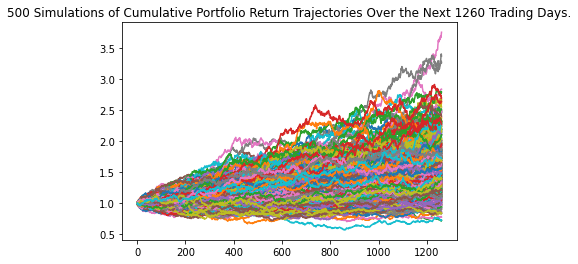

In [53]:
# Plot simulation outcomes (5Y Scenario)
line_plot2 = MC_even_dist2.plot_simulation()

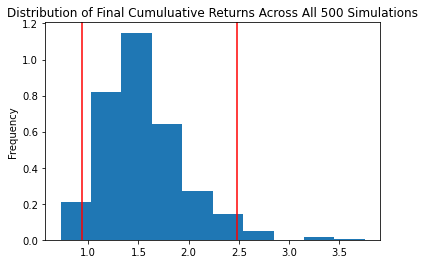

In [54]:
# Plot probability distribution and confidence intervals 
dist_plot2 = MC_even_dist2.plot_distribution()

In [55]:
# Fetch summary statistics from the Monte Carlo simulation results
even_tbl2 = MC_even_dist2.summarize_cumulative_return()

# Print summary statistics
print(even_tbl2)

count           500.000000
mean              1.545322
std               0.405363
min               0.724870
25%               1.269385
50%               1.479929
75%               1.761889
max               3.754262
95% CI Lower      0.938662
95% CI Upper      2.485184
Name: 1260, dtype: float64


### Retirement Analysis (5Y Scenario)

In [56]:
# Set initial investment
initial_investment = 40000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
even_ci_lower2 = round(even_tbl2[8]*30000,2)
even_ci_upper2 = round(even_tbl2[9]*30000,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${even_ci_lower2} and ${even_ci_upper2}")

There is a 95% chance that an initial investment of $40000 in the portfolio over the next 5 years will end within in the range of $28159.86 and $74555.53


### Ten Years Retirement Option

In [57]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_even_dist3 = MCSimulation(
    portfolio_data = df_ticker,
    weights = [.4,.6],
    num_simulation = 500,
    num_trading_days = 252*10
)
# Print the simulation input data
MC_even_dist3.portfolio_data.head()

AGG                                     \
                             open    high       low   close   volume   
timestamp                                                              
2017-03-23 04:00:00+00:00  108.44  108.51  108.2635  108.45  2071485   
2017-03-24 04:00:00+00:00  108.35  108.51  108.3100  108.36  3374871   
2017-03-27 04:00:00+00:00  108.65  108.71  108.5345  108.62  1977292   
2017-03-28 04:00:00+00:00  108.63  108.68  108.3500  108.37  2016097   
2017-03-29 04:00:00+00:00  108.48  108.62  108.4600  108.61  1965626   

                                                                   SPY  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2017-03-23 04:00:00+00:00       10901  108.417635          NaN  233.98   
2017-03-24 04:00:00+00:00       11229  108.398485    -0.000830  234.35   
2017-03-27 04:00:00+00:00       11112  108.600681     0.002399  231.97   
2017-03-28 04:00:00+00:00        9144  108.514754    -0.002302  233.32   
2017-03-29 04:00:00+00:00       10135  108.539517     0.002215  235.00   

                                                                           \
                             high      low   close     volume trade_count   
timestamp                                                                   
2017-03-23 04:00:00+00:00  235.34  233.600  234.03  100410277      333903   
2017-03-24 04:00:00+00:00  235.04  232.960  233.86  112504853      359600   
2017-03-27 04:00:00+00:00  233.92  231.610  233.62   87454452      289784   
2017-03-28 04:00:00+00:00  235.81  233.140  235.32   93483915      277352   
2017-03-29 04:00:00+00:00  235.81  234.725  235.54   61950354      194177   

                                                    
                                 vwap daily_return  
timestamp                                           
2017-03-23 04:00:00+00:00  234.388790          NaN  
2017-03-24 04:00:00+00:00  234.080978    -0.000726  
2017-03-27 04:00:00+00:00  233.041576    -0.001026  
2017-03-28 04:00:00+00:00  234.596748     0.007277  
2017-03-29 04:00:00+00:00  235.429910     0.000935

In [58]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_even_dist3.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.008369,0.993680,1.008026,1.008985,0.998514,0.979132,0.997814,1.006882,0.996524,0.995291,...,0.994556,1.005382,0.996741,0.986878,1.015266,1.018149,0.993296,1.003329,1.005961,0.991968
2,0.998861,0.993988,1.004444,1.006913,1.014151,0.970165,1.000699,1.003209,0.994415,1.003776,...,1.002489,1.008970,1.001319,0.987956,1.009917,1.012236,0.996865,0.995669,1.008937,0.993905
3,1.012437,0.980700,1.006170,1.005953,1.025541,0.972704,1.007251,1.002111,0.999546,1.004612,...,1.010421,1.006282,1.004947,0.991497,1.015341,1.007944,0.984569,1.001401,1.020596,0.995691
4,1.024660,0.987851,1.015591,1.014894,1.031867,0.988784,1.000079,0.999793,0.999795,0.981095,...,1.002401,1.015822,1.022525,1.001793,1.024682,1.008025,0.988445,1.007106,1.016582,1.001904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,2.936036,3.232306,2.650013,3.279100,1.838046,2.376422,2.077418,2.910166,0.918157,2.828496,...,2.148876,2.286090,1.483317,2.702216,1.109225,2.590469,1.703678,1.740704,2.009244,2.693500
2517,2.910362,3.249145,2.618249,3.285863,1.828460,2.369137,2.064306,2.943228,0.919458,2.821806,...,2.151726,2.287993,1.489843,2.689721,1.110792,2.566067,1.689208,1.735548,2.001584,2.705712
2518,2.892151,3.222672,2.611738,3.308305,1.829752,2.361297,2.047448,2.913637,0.926576,2.839301,...,2.137081,2.261811,1.481838,2.682665,1.116918,2.559268,1.685058,1.732993,2.006841,2.748983
2519,2.878247,3.222585,2.588539,3.291187,1.810161,2.345075,2.026211,2.884668,0.932730,2.871362,...,2.145345,2.263492,1.506334,2.686916,1.108578,2.593688,1.676358,1.719798,2.034283,2.761228


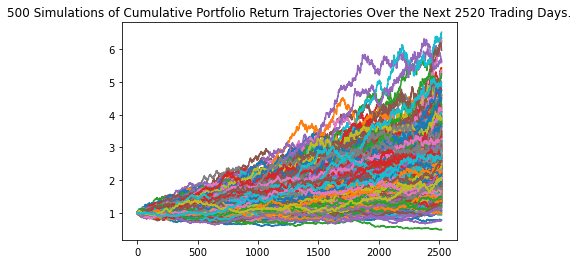

In [59]:
# Plot simulation outcomes (10Y Scenario)
line_plot3 = MC_even_dist3.plot_simulation()

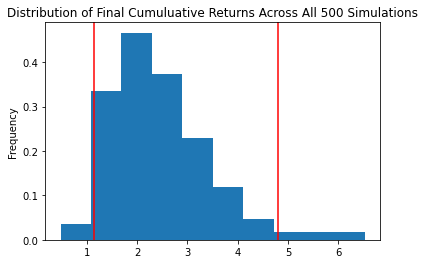

In [60]:
# Plot probability distribution and confidence intervals 
dist_plot3 = MC_even_dist3.plot_distribution()

In [61]:
# Fetch summary statistics from the Monte Carlo simulation results
even_tbl3 = MC_even_dist3.summarize_cumulative_return()

# Print summary statistics
print(even_tbl3)

count           500.000000
mean              2.448026
std               0.974160
min               0.480762
25%               1.742659
50%               2.281488
75%               2.951957
max               6.527307
95% CI Lower      1.139893
95% CI Upper      4.806920
Name: 2520, dtype: float64


### Retirement Analysis (10Y Scenario)

In [62]:
# Set initial investment
initial_investment = 40000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
even_ci_lower3 = round(even_tbl3[8]*30000,2)
even_ci_upper3 = round(even_tbl3[9]*30000,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${even_ci_lower} and ${even_ci_upper}")

There is a 95% chance that an initial investment of $40000 in the portfolio over the next 10 years will end within in the range of $101259.7 and $1138785.47
